In [ ]:
import sys
!{sys.executable} -m pip install uv
!{sys.executable} -m uv pip sync ../requirements.txt

# Imports

In [2]:
import os

os.environ["BAYBE_TELEMETRY_ENABLED"] = "false"

import warnings
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.stats as stats
from itertools import combinations
import pandas as pd

from baybe.targets import NumericalTarget
from baybe.objective import Objective
from baybe import Campaign
from baybe.parameters import (
    NumericalDiscreteParameter,
    SubstanceParameter,
    TaskParameter,
)
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios

from utils import backtest_plot

script_path = Path(os.getcwd())
if script_path.name != "notebooks":
    warnings.warn(
        "Please run this script from the 'notebooks' directory to ensure that the data "
        "is loaded correctly."
    )
    raise SystemExit

data_dir = script_path.parent / "data"
lookup_file = "direct_arylation.csv"
lookup_file_path = data_dir / lookup_file
results_dir = script_path.parent / "results"
figures_dir = script_path.parent / "figures"
if not data_dir.exists():
    raise FileNotFoundError(
        f"Data directory {data_dir} not found. Please make sure to run this script "
        f"from the 'notebooks' directory."
    )
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
if not figures_dir.exists():
    figures_dir.mkdir(exist_ok=True)

warnings.filterwarnings("ignore")

import baybe

baybe.__version__

'0.12.2'

# Correlation
### of Data Between Different Temperatures / Concentrations

## Settings
Check if the derivative of the yield with respect to the variable of interest per reaction should be plotted.

In [3]:
PLOT_GRADIENT = False
temperatures = [90, 105, 120]
concentrations = [0.057, 0.1, 0.153]
ylims = {  # y axis limits for consistency
    90: [15, 90],
    105: [25, 105],
    120: [30, 105],
    0.057: [20, 100],
    0.1: [20, 95],
    0.153: [20, 105],
}
parameters_to_analyze = {"temperature": temperatures, "concentration": concentrations}
units = {"temperature": "°C", "concentration": "mol / l"}

## Visualization

Pearson correlation coefficient (PCC) between yields at 90 °C and 105 °C: 0.88
Spearman rank correlation coefficient (SCC) between yields at 90 °C and 105 °C: 0.92
R2 value: 0.77


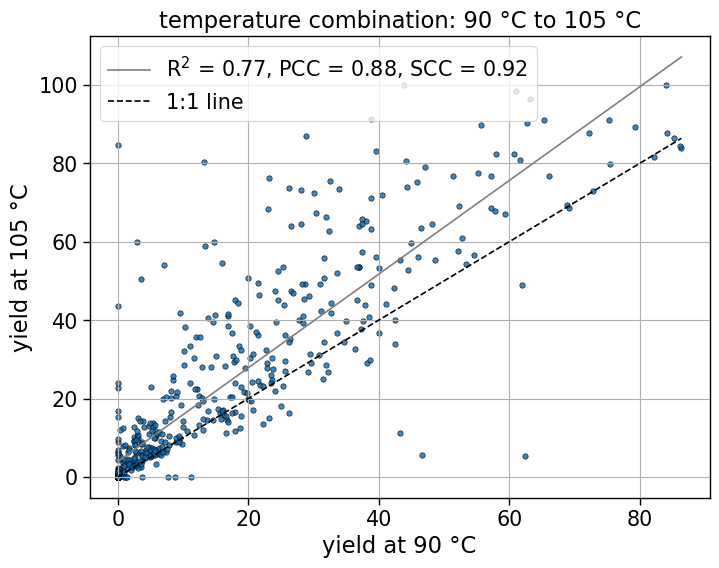

Pearson correlation coefficient (PCC) between yields at 90 °C and 120 °C: 0.77
Spearman rank correlation coefficient (SCC) between yields at 90 °C and 120 °C: 0.88
R2 value: 0.60


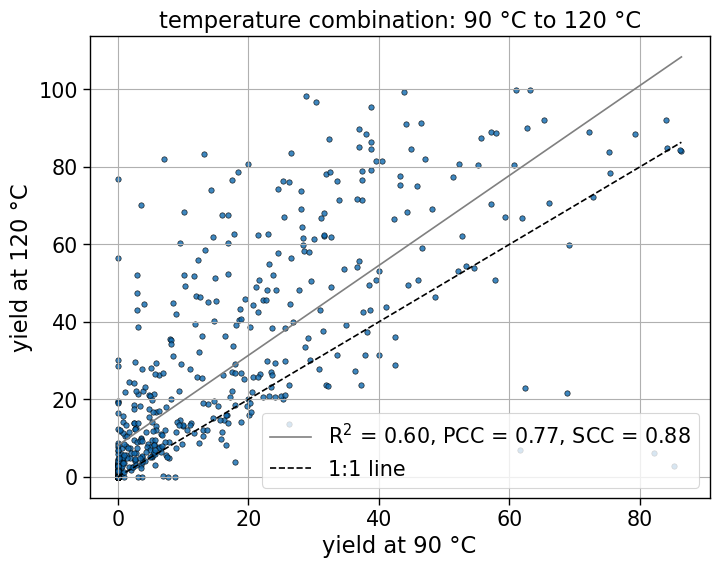

Pearson correlation coefficient (PCC) between yields at 105 °C and 120 °C: 0.91
Spearman rank correlation coefficient (SCC) between yields at 105 °C and 120 °C: 0.93
R2 value: 0.83


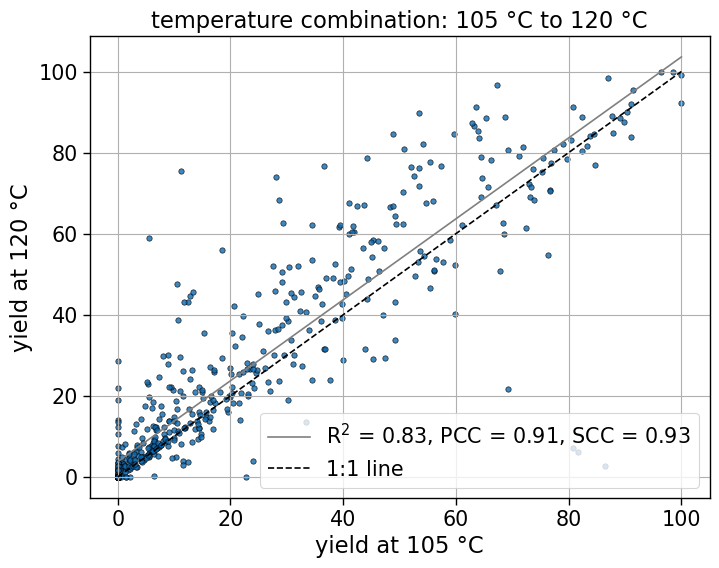

Pearson correlation coefficient (PCC) between yields at 0.057 mol / l and 0.1 mol / l: 0.92
Spearman rank correlation coefficient (SCC) between yields at 0.057 mol / l and 0.1 mol / l: 0.93
R2 value: 0.85


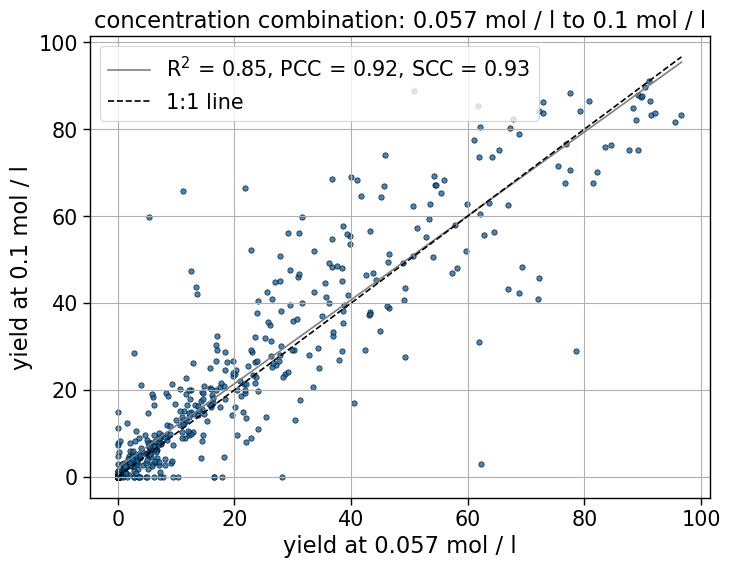

Pearson correlation coefficient (PCC) between yields at 0.057 mol / l and 0.153 mol / l: 0.87
Spearman rank correlation coefficient (SCC) between yields at 0.057 mol / l and 0.153 mol / l: 0.92
R2 value: 0.75


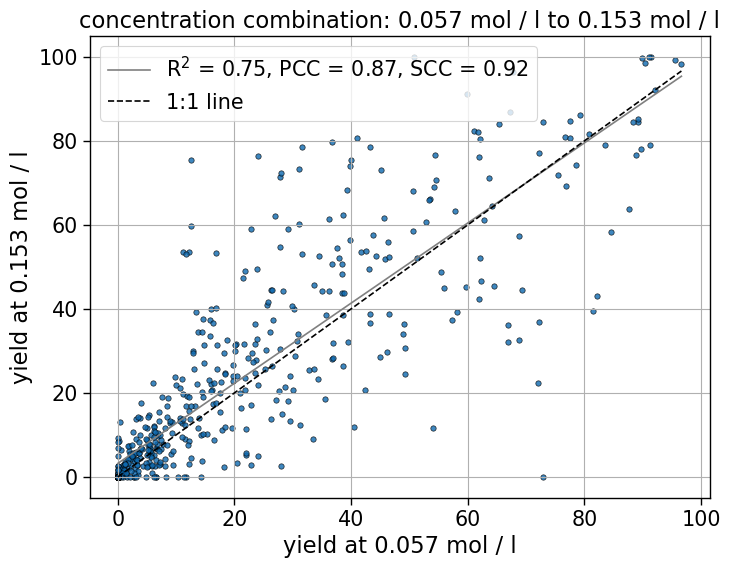

Pearson correlation coefficient (PCC) between yields at 0.1 mol / l and 0.153 mol / l: 0.92
Spearman rank correlation coefficient (SCC) between yields at 0.1 mol / l and 0.153 mol / l: 0.93
R2 value: 0.85


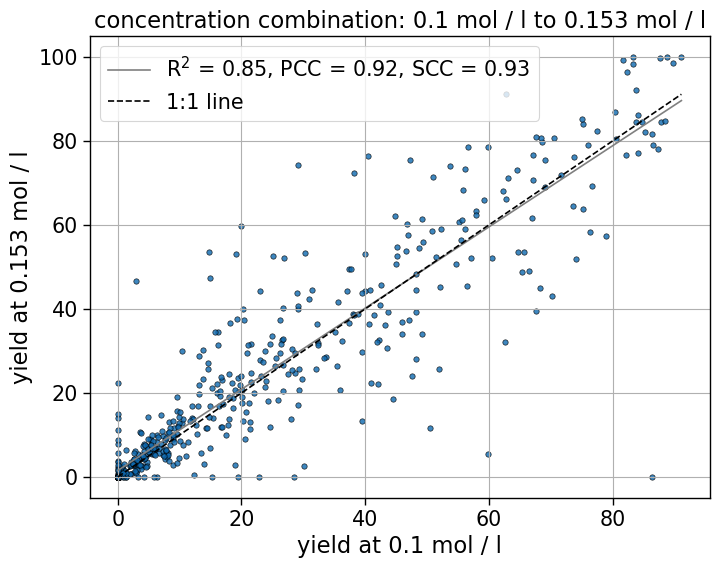

In [4]:
def analyze_data(file_path: Path, parameter_to_analyze: str):
    data = defaultdict(lambda: defaultdict(list))
    with open(file_path, "r") as file:
        csv_reader = csv.DictReader(file)
        config = {}
        for row in csv_reader:
            config["base"] = row["Base"]
            config["ligand"] = row["Ligand"]
            config["solvent"] = row["Solvent"]
            config["concentration"] = float(row["Concentration"])
            config["temperature"] = int(row["Temp_C"])
            yield_value = float(row["yield"])

            # config key consists of every key in the config dictionary, except for
            # the parameter to analyze
            config_key = tuple(
                value for key, value in config.items() if key != parameter_to_analyze
            )
            data[config_key][config[parameter_to_analyze]].append(yield_value)

    # form all possible combinations of the parameter to analyze
    permutations = list(combinations(parameters_to_analyze[parameter_to_analyze], 2))

    for comb in permutations:
        v1, v2 = comb
        slopes = []

        yields_v1: list[float] = []
        yields_v2: list[float] = []

        for parameter_config, parameter_combination in data.items():
            if v1 in parameter_combination and v2 in parameter_combination:
                yield_v1 = parameter_combination[v1][0]
                yields_v1.append(yield_v1)
                yield_v2 = parameter_combination[v2][0]
                yields_v2.append(yield_v2)
                slope = (yield_v2 - yield_v1) / (v2 - v1)
                slopes.append(slope)

        if PLOT_GRADIENT:
            # Gradient of yield with respect to temperature
            plt.figure(figsize=(8, 6))
            plt.scatter(
                range(len(slopes)),
                slopes,
                color="#0e69af",
                edgecolor="black",
                s=15,
                alpha=0.8,
                linewidth=0.5,
            )
            plt.xlabel("reaction")
            plt.ylabel(f"slope (yield Change per {units[parameter_to_analyze]})")
            plt.title(
                f"{parameter_to_analyze} combination: "
                f"{v1} {units[parameter_to_analyze]} "
                f"to {v2} {units[parameter_to_analyze]}"
            )
            plt.grid(True)
            plt.savefig(
                figures_dir / f"pairplot_{parameter_to_analyze}_{v1}_{v2}_slope.svg"
            )
            plt.show()

        ## Correlation between yields at v1 and v2
        corr, _ = stats.pearsonr(yields_v1, yields_v2)
        print(
            f"Pearson correlation coefficient (PCC) between yields at "
            f"{v1} {units[parameter_to_analyze]} and "
            f"{v2} {units[parameter_to_analyze]}: {corr:.2f}"
        )
        scc, _ = stats.spearmanr(yields_v1, yields_v2)
        print(
            f"Spearman rank correlation coefficient (SCC) between yields at "
            f"{v1} {units[parameter_to_analyze]} and "
            f"{v2} {units[parameter_to_analyze]}: {scc:.2f}"
        )
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            yields_v1, yields_v2
        )
        print(f"R2 value: {r_value**2:.2f}")

        # plot the correlation between the yields at v1 and v2
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(
            yields_v1,
            yields_v2,
            color="#0e69af",
            edgecolor="black",
            s=15,
            alpha=0.8,
            linewidth=0.5,
        )
        # include the regression line
        x = [min(yields_v1), max(yields_v1)]
        y = [slope * x_i + intercept for x_i in x]
        ax.plot(
            x,
            y,
            color="grey",
            label=f"R$^2$ = {r_value**2:.2f}, PCC = {corr:.2f}, SCC = {scc:.2f}",
        )
        ax.set_xlabel(f"yield at {v1} {units[parameter_to_analyze]}")
        ax.set_ylabel(f"yield at {v2} {units[parameter_to_analyze]}")
        ax.set_title(
            f"{parameter_to_analyze} combination: "
            f"{v1} {units[parameter_to_analyze]} to "
            f"{v2} {units[parameter_to_analyze]}"
        )
        # include 1:1 line
        ax.plot(x, x, color="black", linestyle="--", label="1:1 line")
        ax.grid(True)
        # show the legend
        ax.legend()
        plt.savefig(figures_dir / f"pairplot_{parameter_to_analyze}_{v1}_{v2}.svg")
        plt.show()


for parameter, _ in parameters_to_analyze.items():
    analyze_data(lookup_file_path, parameter)

# Transfer Learning Settings

## Convenience Functions

In [5]:
def save_and_plot_simulation(results: pd.DataFrame, figure_name: str, **kwargs) -> None:
    results.rename(
        columns={
            "Scenario": "% of data used",
            "Num_Experiments": "Number of experiments",
            "yield_CumBest": "Running best yield",
        },
        inplace=True,
    )

    path_to_results = results_dir / f"{figure_name}.csv"
    results.to_csv(path_to_results, index=False)

    backtest_plot(
        df=results,
        figure_name=figure_name,
        x="Number of experiments",
        y="Running best yield",
        hue="% of data used",
        path=figures_dir,
        **kwargs,
    )

## Variables

In [6]:
from direct_arylation import substances, concentrations, temperatures, lookup
from baybe.utils.random import set_random_seed

N_DOE_ITERATIONS = 10
BATCH_SIZE = 2
N_MC_ITERATIONS = 100
set_random_seed(1337)

lookup = pd.read_csv(lookup_file_path)

objective = Objective(
    mode="SINGLE", targets=[NumericalTarget(name="yield", mode="MAX")]
)
encoding = "RDKIT"  # Define the substance encoding
sample_fractions = [0.01, 0.02, 0.05, 0.1, 0.2]

# Transfer Learning via `TaskParameter`

## Temperatures



Temperature: 90
Taking additional data from ['105', '120'] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [59:12<00:00, 35.53s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:06:02<00:00, 39.62s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:09:06<00:00, 41.46s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:13:58<00:00, 44.39s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [1:54:51<00:00, 68.92s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:06<00:00,  1.27s/it]


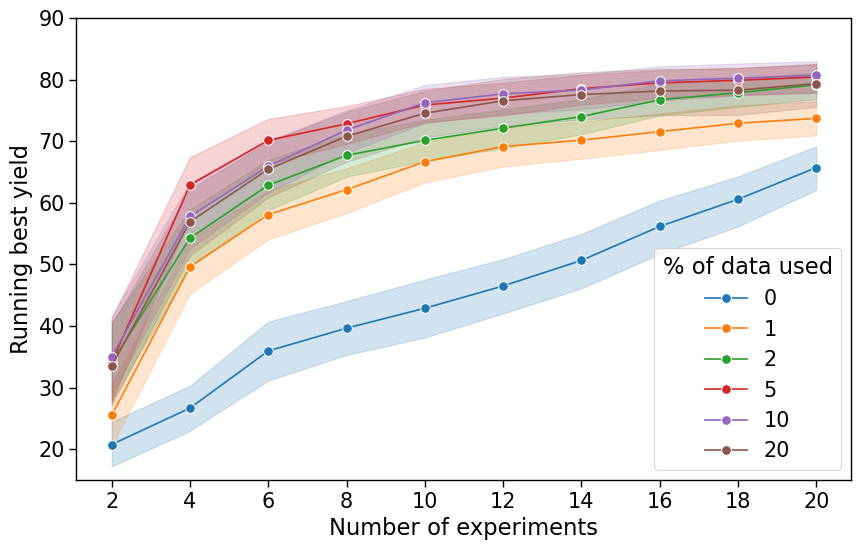



Temperature: 105
Taking additional data from ['90', '120'] into account.

Percentage of data used:  0.01


100%|####################################################################################################################################################################################################################################| 100/100 [1:05:05<00:00, 39.05s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:07:56<00:00, 40.76s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:17:58<00:00, 46.79s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:20:25<00:00, 48.26s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [2:03:29<00:00, 74.09s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:10<00:00,  1.30s/it]


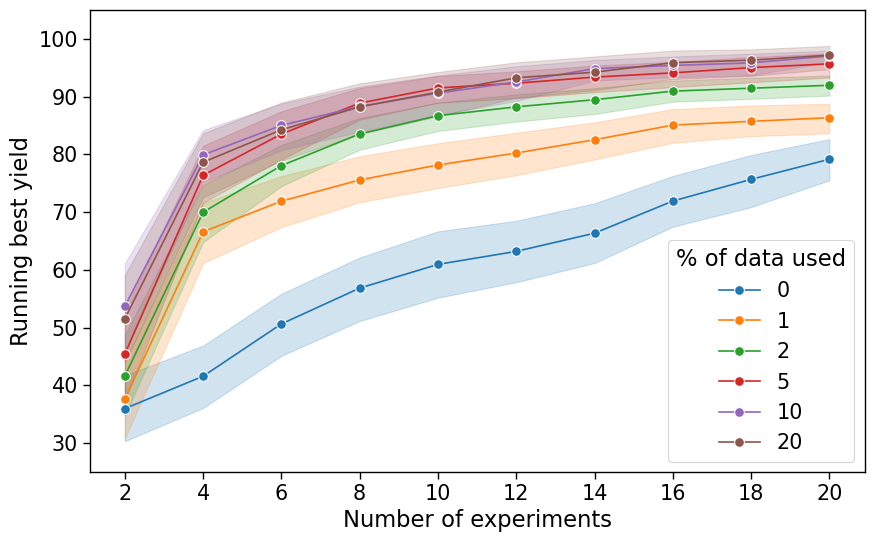



Temperature: 120
Taking additional data from ['90', '105'] into account.

Percentage of data used:  0.01


100%|####################################################################################################################################################################################################################################| 100/100 [1:00:13<00:00, 36.14s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:14:38<00:00, 44.79s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:15:53<00:00, 45.54s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:22:16<00:00, 49.36s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [2:03:18<00:00, 73.99s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:09<00:00,  1.29s/it]


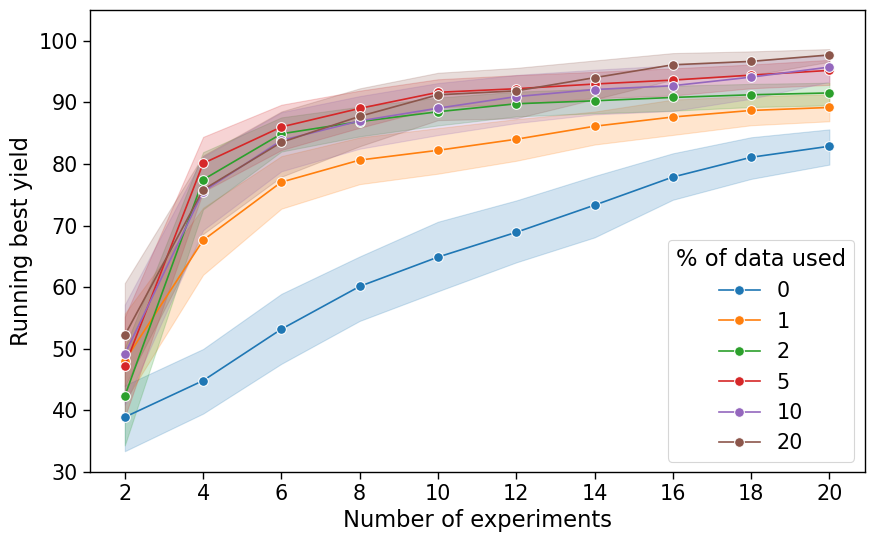

In [7]:
lookup_T = lookup.copy(deep=True)
lookup_T["Temp_C"] = lookup_T["Temp_C"].astype(str)

for temp in temperatures:
    print(f"\n\nTemperature: {temp}")
    excluded_temps = [str(t) for t in temperatures if str(t) != str(temp)]

    print(f"Taking additional data from {excluded_temps} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=substances["solvents"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Base", data=substances["bases"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Ligand", data=substances["ligands"], encoding=encoding
                ),
                TaskParameter(  # For transfer learning we treat the numbers as labels
                    name="Temp_C",
                    values=[str(t) for t in temperatures],
                    active_values=[str(temp)],
                ),
                NumericalDiscreteParameter(
                    name="Concentration", values=concentrations, tolerance=0.001
                ),
            ]
        ),
        objective=objective,
    )
    # Lookup table that contains all data except the data for the current temperature.
    lookup_other_data = lookup_T[lookup_T["Temp_C"] != str(temp)].copy(deep=True)

    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Percentage of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100 * p)}": campaign},
            lookup_T,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
        )
        results.append(result_fraction)

    print("Percentage of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup_T,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])

    save_and_plot_simulation(
        results, f"transfer_learning_T{temp}_taskparam", ylim=ylims[temp]
    )

## Concentrations



Concentration: 0.057
Taking additional data from ['0.1', '0.153'] into account.

Percentage of data used:  0.01


100%|####################################################################################################################################################################################################################################| 100/100 [1:01:12<00:00, 36.72s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:11:55<00:00, 43.16s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:18:28<00:00, 47.09s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:34:00<00:00, 56.40s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [2:32:45<00:00, 91.66s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:16<00:00,  1.36s/it]


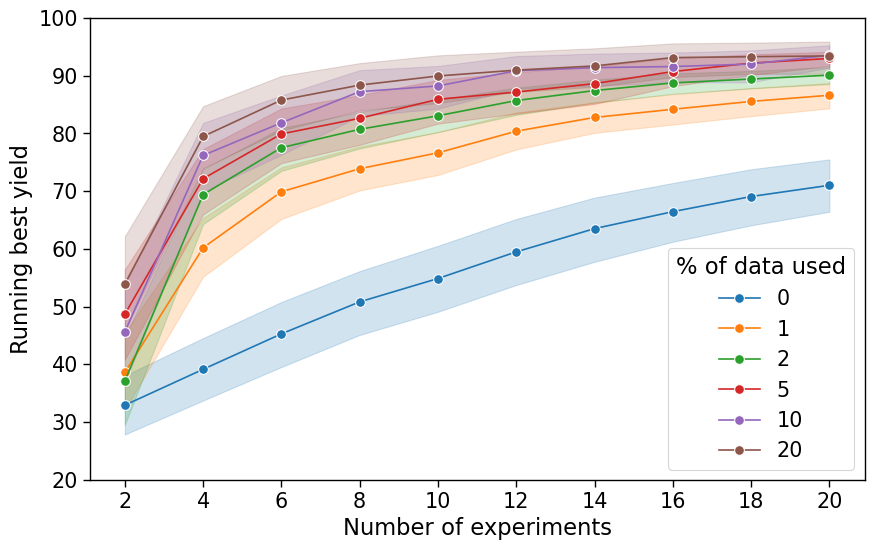



Concentration: 0.1
Taking additional data from ['0.057', '0.153'] into account.

Percentage of data used:  0.01


100%|####################################################################################################################################################################################################################################| 100/100 [1:09:54<00:00, 41.94s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:21:01<00:00, 48.61s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:23:56<00:00, 50.36s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:36:40<00:00, 58.01s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [2:31:35<00:00, 90.95s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:11<00:00,  1.32s/it]


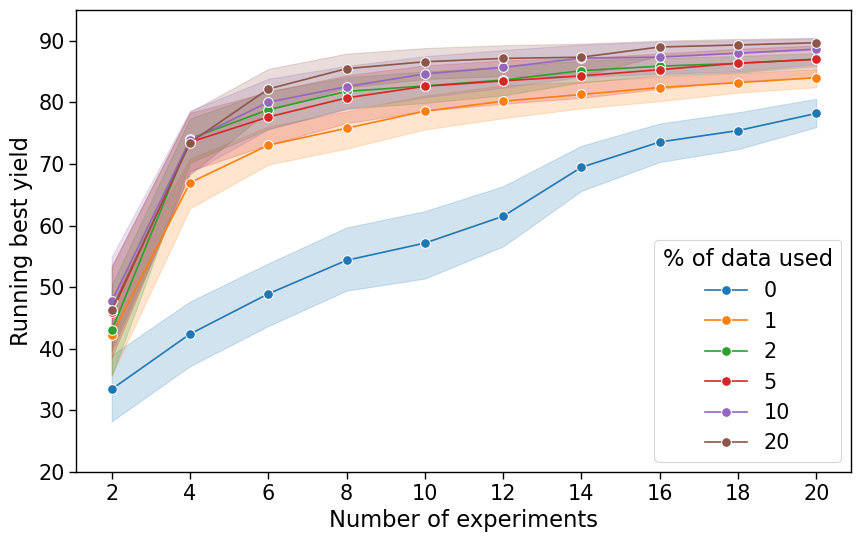



Concentration: 0.153
Taking additional data from ['0.057', '0.1'] into account.

Percentage of data used:  0.01


100%|####################################################################################################################################################################################################################################| 100/100 [1:04:46<00:00, 38.86s/it]


Percentage of data used:  0.02


100%|####################################################################################################################################################################################################################################| 100/100 [1:21:08<00:00, 48.69s/it]


Percentage of data used:  0.05


100%|####################################################################################################################################################################################################################################| 100/100 [1:23:06<00:00, 49.87s/it]


Percentage of data used:  0.1


100%|####################################################################################################################################################################################################################################| 100/100 [1:34:01<00:00, 56.41s/it]


Percentage of data used:  0.2


100%|####################################################################################################################################################################################################################################| 100/100 [2:24:04<00:00, 86.44s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [02:15<00:00,  1.36s/it]


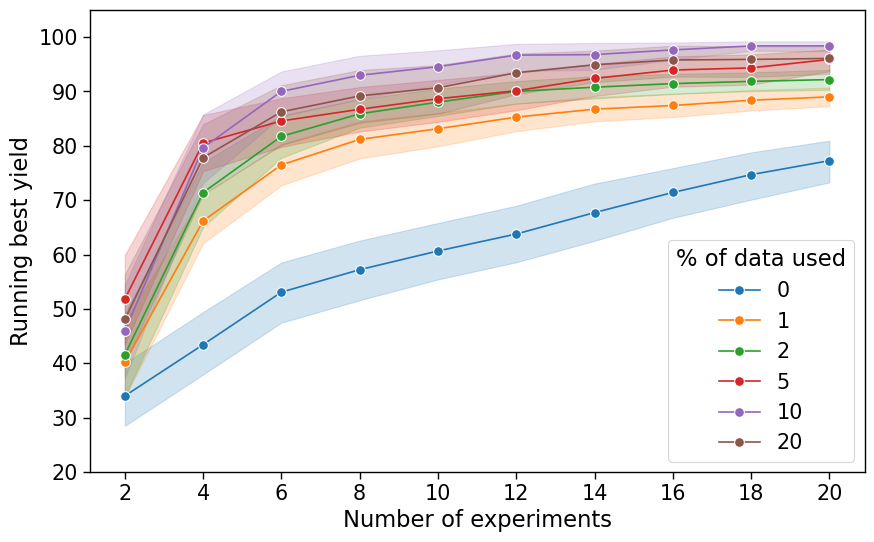

In [8]:
lookup_c = lookup.copy(deep=True)
lookup_c["Concentration"] = lookup_c["Concentration"].astype(str)
for conc in concentrations:
    print(f"\n\nConcentration: {conc}")
    excluded_concs = [str(c) for c in concentrations if str(c) != str(conc)]

    print(f"Taking additional data from {excluded_concs} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=substances["solvents"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Base", data=substances["bases"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Ligand", data=substances["ligands"], encoding=encoding
                ),
                NumericalDiscreteParameter(
                    name="Temp_C",
                    values=temperatures,
                    tolerance=2,
                ),
                TaskParameter(  # For transfer learning we treat the numbers as labels
                    name="Concentration",
                    values=[str(c) for c in concentrations],
                    active_values=[str(conc)],
                ),
            ]
        ),
        objective=objective,
    )
    lookup_other_data = lookup_c[lookup_c["Concentration"] != str(conc)].copy(deep=True)

    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Percentage of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100 * p)}": campaign},
            lookup_c,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
        )
        results.append(result_fraction)

    print("Percentage of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup_c,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])

    save_and_plot_simulation(
        results, f"transfer_learning_c{conc}_taskparam", ylim=ylims[conc]
    )

# Transfer Learning via Explicit Numerical Parameter
This is only possible if the parameters distinguishing the campaigns and their values are known. In general, the parameters that distinguish campaigns from different labs or locations are unknown and even if they are known, their values at time of execution are not recorded. This explicit numerical modeling is expected to perform better than the transfer learning approach, hence we will use it as a comparison baseline to judge TL performance.

## Temperatures



Temperature: 90
Taking additional data from [105, 120] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:25<00:00,  1.17it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:39<00:00,  1.01it/s]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:12<00:00,  1.33s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:56<00:00,  1.76s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [04:34<00:00,  2.74s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [00:59<00:00,  1.67it/s]


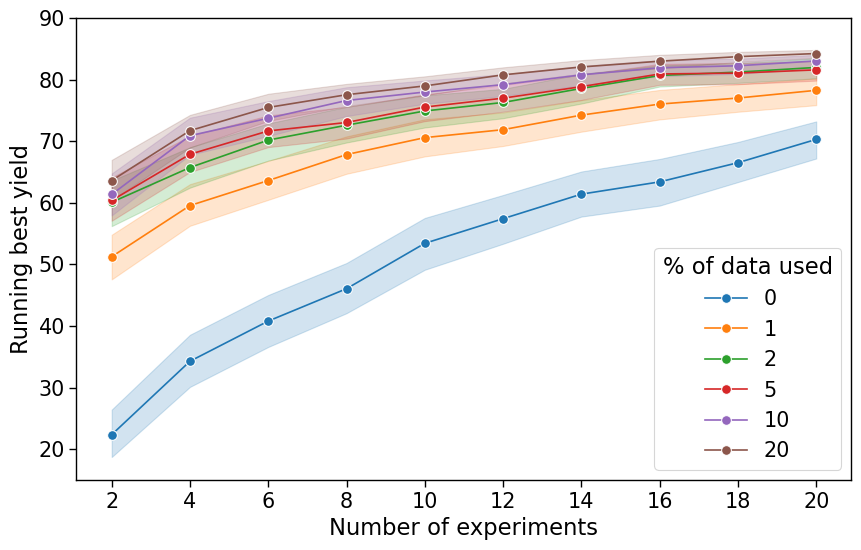



Temperature: 105
Taking additional data from [90, 120] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:23<00:00,  1.20it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:39<00:00,  1.00it/s]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:15<00:00,  1.36s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:59<00:00,  1.79s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [04:38<00:00,  2.79s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [01:01<00:00,  1.63it/s]


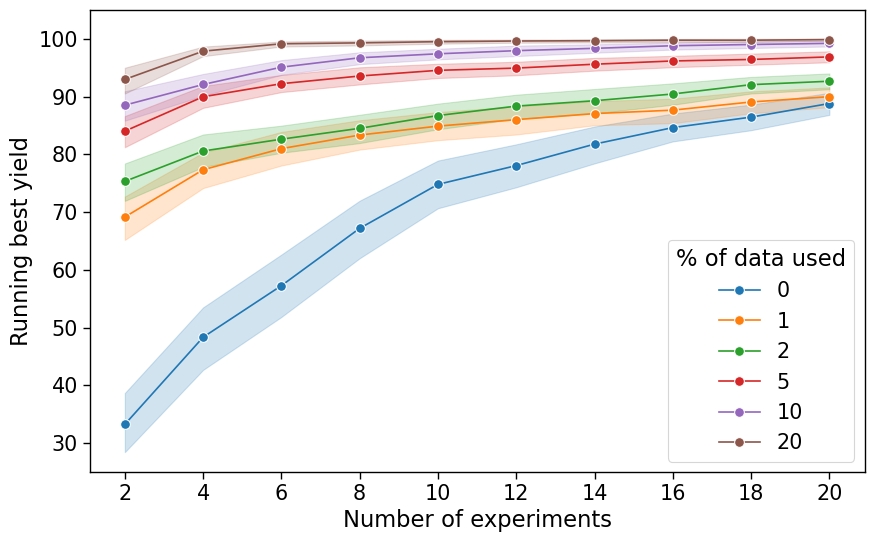



Temperature: 120
Taking additional data from [90, 105] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:27<00:00,  1.14it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:46<00:00,  1.06s/it]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:15<00:00,  1.35s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:59<00:00,  1.79s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [04:46<00:00,  2.86s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [01:03<00:00,  1.57it/s]


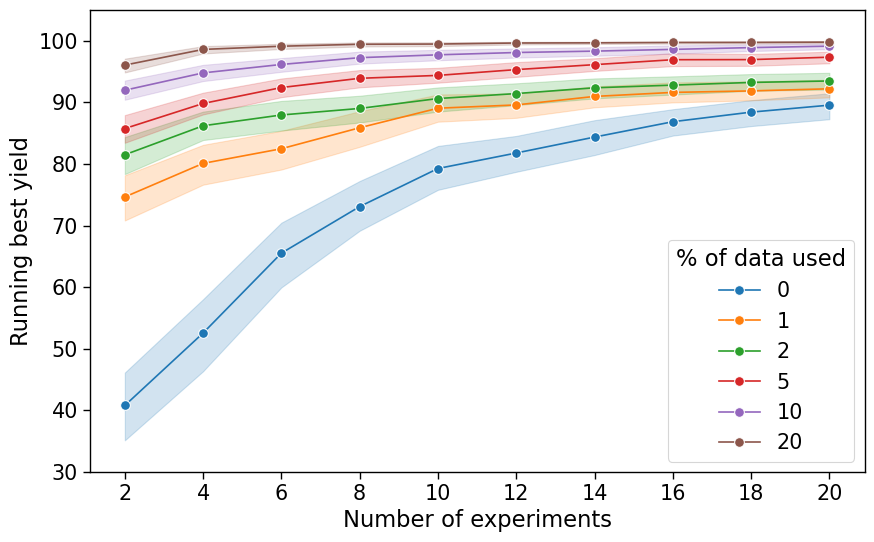

In [9]:
for temp in temperatures:
    print(f"\n\nTemperature: {temp}")
    excluded_temps = [t for t in temperatures if t != temp]
    print(f"Taking additional data from {excluded_temps} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=substances["solvents"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Base", data=substances["bases"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Ligand", data=substances["ligands"], encoding=encoding
                ),
                NumericalDiscreteParameter(name="Temp_C", values=temperatures),
                NumericalDiscreteParameter(name="Concentration", values=concentrations),
            ]
        ),
        objective=objective,
    )

    # Exclude temperatures that are not the current fixed one from being recommended
    campaign.toggle_discrete_candidates(
        pd.DataFrame({"Temp_C": [temp]}), exclude=True, complement=True
    )
    lookup_other_data = lookup[lookup["Temp_C"] != temp].copy(deep=True)

    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Percentage of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100 * p)}": campaign},
            lookup,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
        )
        results.append(result_fraction)
    print("Percentage of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])

    save_and_plot_simulation(
        results, f"transfer_learning_T{temp}_numparam", ylim=ylims[temp]
    )

## Concentrations



Concentration: 0.057
Taking additional data from [0.1, 0.153] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:29<00:00,  1.11it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:42<00:00,  1.02s/it]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:16<00:00,  1.36s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:59<00:00,  1.79s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [05:01<00:00,  3.02s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [01:01<00:00,  1.63it/s]


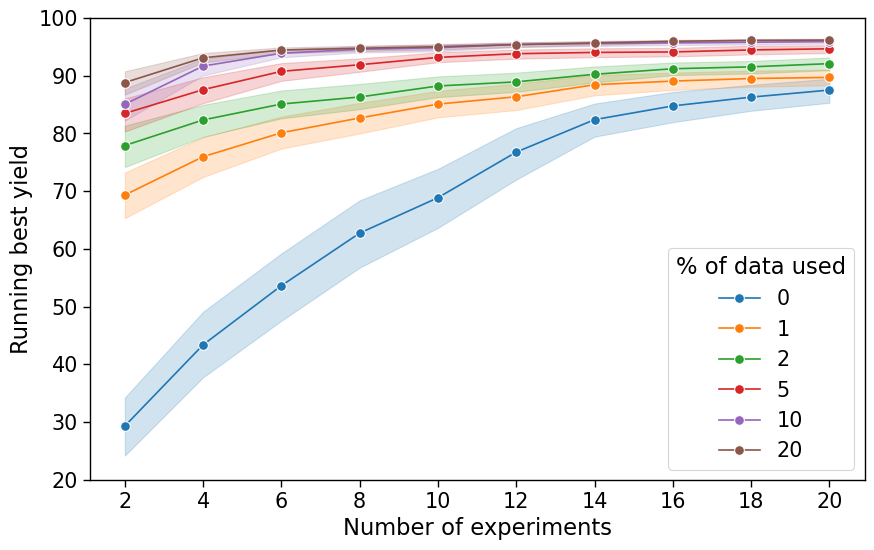



Concentration: 0.1
Taking additional data from [0.057, 0.153] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:26<00:00,  1.16it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:44<00:00,  1.04s/it]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:15<00:00,  1.35s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:57<00:00,  1.77s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [04:35<00:00,  2.75s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [01:02<00:00,  1.59it/s]


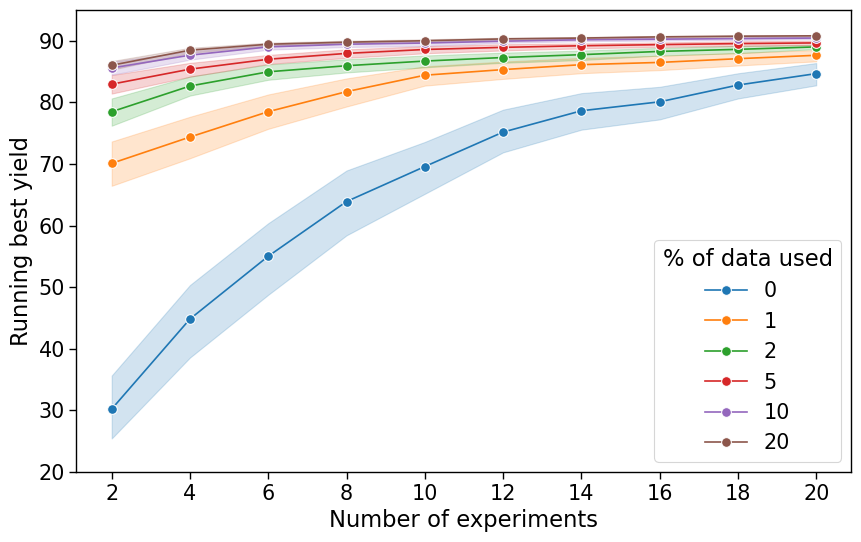



Concentration: 0.153
Taking additional data from [0.057, 0.1] into account.

Percentage of data used:  0.01


100%|######################################################################################################################################################################################################################################| 100/100 [01:27<00:00,  1.15it/s]


Percentage of data used:  0.02


100%|######################################################################################################################################################################################################################################| 100/100 [01:45<00:00,  1.06s/it]


Percentage of data used:  0.05


100%|######################################################################################################################################################################################################################################| 100/100 [02:18<00:00,  1.39s/it]


Percentage of data used:  0.1


100%|######################################################################################################################################################################################################################################| 100/100 [02:58<00:00,  1.79s/it]


Percentage of data used:  0.2


100%|######################################################################################################################################################################################################################################| 100/100 [04:49<00:00,  2.90s/it]


Percentage of data used: 0.0


100%|######################################################################################################################################################################################################################################| 100/100 [00:59<00:00,  1.68it/s]


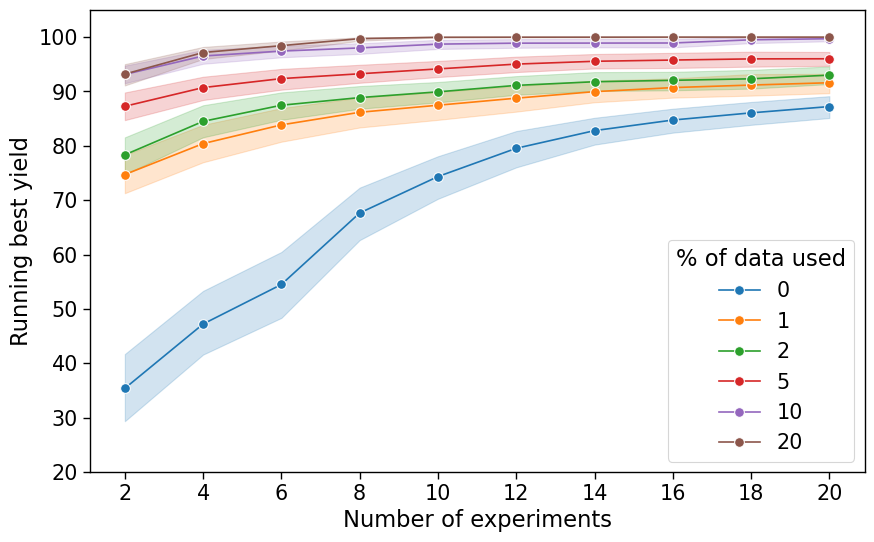

In [10]:
for conc in concentrations:
    print(f"\n\nConcentration: {conc}")
    excluded_concs = [c for c in concentrations if c != conc]
    print(f"Taking additional data from {excluded_concs} into account.\n")
    campaign = Campaign(
        searchspace=SearchSpace.from_product(
            parameters=[
                SubstanceParameter(
                    name="Solvent", data=substances["solvents"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Base", data=substances["bases"], encoding=encoding
                ),
                SubstanceParameter(
                    name="Ligand", data=substances["ligands"], encoding=encoding
                ),
                NumericalDiscreteParameter(
                    name="Concentration", values=concentrations, tolerance=0.001
                ),
                NumericalDiscreteParameter(
                    name="Temp_C",
                    values=temperatures,
                    tolerance=2,
                ),
            ]
        ),
        objective=objective,
    )

    # Exclude concentrations that are not the current fixed one
    campaign.toggle_discrete_candidates(
        pd.DataFrame({"Concentration": [conc]}), exclude=True, complement=True
    )
    lookup_other_data = lookup[lookup["Concentration"] != conc].copy(deep=True)

    results: list[pd.DataFrame] = []
    for p in sample_fractions:
        print("Percentage of data used: ", p)
        result_fraction = simulate_scenarios(
            {f"{int(100 * p)}": campaign},
            lookup,
            initial_data=[
                lookup_other_data.sample(frac=p) for _ in range(N_MC_ITERATIONS)
            ],
            batch_size=BATCH_SIZE,
            n_doe_iterations=N_DOE_ITERATIONS,
        )
        results.append(result_fraction)
    print("Percentage of data used: 0.0")
    result_baseline = simulate_scenarios(
        {"0": campaign},
        lookup,
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )
    results = pd.concat([result_baseline, *results])

    save_and_plot_simulation(
        results, f"transfer_learning_c{conc}_numparam", ylim=ylims[conc]
    )